# LLM - Detect AI Generated Text
# BERT (Bidirectional Encoder Representation for Transformer)

## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay
import keras

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import Dataset
from transformers import DataCollatorWithPadding

2024-01-14 02:08:42.240454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 02:08:42.240503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 02:08:42.272999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 02:08:42.338831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 02:08:43.511569: W tensorflow/compiler/tf2

## Random Downsampling

In [2]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

## ROC AUC curve

In [3]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    tf = to_tf_dateset(x_val,y_val)
    #print(len(tf))
    y_pred = model.predict(tf)[0]
    y_pred = [p for prr in y_pred for p in prr]
    assert len(y_pred) == len(y_val)
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



In [4]:
initial_dataset = pd.read_csv("../data/train_essays.csv")
custom_data = pd.read_csv("../data/custom_essays.csv")
downloaded_data_1 = pd.read_csv("../data/train_v3_drcat_01.csv")

## Adding new Data

Describing the imbalance of this dataset in terms of ration is 1:500. The dataset presents sever imbalance. Previous aproches using only 20 new LLM generated examples manually and random Downsampling technic, didn't reach a higher score than 0.56. 

Concluding that more new data is needed, i downloaded data shared by competitors.

In [5]:
downloaded_data_1["prompt_id"] = downloaded_data_1["prompt_name"].apply(lambda name : 0 if name == "Car-free cities" else 1 if name == "Does the electoral college work?" else 21 )
downloaded_data_1 = downloaded_data_1[["prompt_id","text","label"]].rename(columns={"label":"generated"})

In [6]:
new_data = pd.concat([custom_data,downloaded_data_1],axis=0,ignore_index=True)
new_data["id"] = range(0,new_data.shape[0])

In [7]:
new_data

,id,prompt_id,text,generated
0,0,0,The Advantages of Limiting Car Usage in Suburb...,1
1,1,0,Paris' Driving Ban: A Temporary Solution to En...,1
2,2,0,Bogota's Car-Free Day: A Model for Sustainable...,1
3,3,0,Shifting Trends: The Decline of Car Culture in...,1
4,4,0,The End of Car Culture and the Rise of Sustain...,1
...,...,...,...,...
65525,65525,1,"\n\nDear Senator,\n\nI am writing to you regar...",1
65526,65526,1,\n\nI remember the day distinctively. I was si...,1
65527,65527,1,"\n\nDear Senator, \n\nI am writing this letter...",1
65528,65528,1,"\n\nDear Senator,\n\nI am writing to urge you ...",1


In [8]:
target_data = pd.concat([initial_dataset,new_data],ignore_index=True,axis=0)
target_data

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
66903,65525,1,"\n\nDear Senator,\n\nI am writing to you regar...",1
66904,65526,1,\n\nI remember the day distinctively. I was si...,1
66905,65527,1,"\n\nDear Senator, \n\nI am writing this letter...",1
66906,65528,1,"\n\nDear Senator,\n\nI am writing to urge you ...",1


### Data cleaning

In [9]:
target_data = pd.concat([initial_dataset[100:200],initial_dataset[initial_dataset["generated"]==1],custom_data])

In [10]:
print(target_data.shape)
target_data.drop_duplicates(subset=["text"],inplace=True,keep="first")
target_data = target_data.dropna()
target_data.reset_index(inplace=True,drop=True)
print(target_data.shape)

(125, 4)
(125, 4)


## Tokenization for DistilBERT

DistilBERT is a lighter version of BERT.

In [11]:
tokenized_df = target_data.copy()
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized = target_data["text"].apply(lambda text: tokenizer(text,truncation=True, padding=True))
tokenized_df["input_ids"] = tokenized.apply(lambda x : x['input_ids'])
tokenized_df["attention_mask"] = tokenized.apply(lambda x : x['attention_mask'])
tokenized_df

,id,prompt_id,text,generated,input_ids,attention_mask
0,1648c117,1,"Dear Senator, I am a student writing to you th...",0,"[101, 6203, 5205, 1010, 1045, 2572, 1037, 3076...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,16652a46,1,The electoral college is a bad thing because v...,0,"[101, 1996, 6092, 2267, 2003, 1037, 2919, 2518...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1669258f,0,In the recent years the state of the country h...,0,"[101, 1999, 1996, 3522, 2086, 1996, 2110, 1997...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,16a0afd8,1,"Dear Senator, The Electoral College was create...",0,"[101, 6203, 5205, 1010, 1996, 6092, 2267, 2001...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,16b2bb2b,0,"As our atmosphere constantly changes, so do ou...",0,"[101, 2004, 2256, 7224, 7887, 3431, 1010, 2061...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
120,17,0,Limiting car usage stands as a pivotal strateg...,1,"[101, 14879, 2482, 8192, 4832, 2004, 1037, 203...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
121,18,1,"\nJohn Smith\n123 Main Street\nCityville, Stat...",1,"[101, 2198, 3044, 13138, 2364, 2395, 2103, 307...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
122,19,1,"Dear Senator,\n\nI am writing to express my op...",1,"[101, 6203, 5205, 1010, 1045, 2572, 3015, 2000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
123,18,0,\nThe advantages of limiting car usage are num...,1,"[101, 1996, 12637, 1997, 14879, 2482, 8192, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
del target_data
del custom_data
del initial_dataset
del new_data
del downloaded_data_1

## Arquitecture

In [13]:
id2labels = {1:"generated"}
labels2id = {"generated":1}
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=1,
    id2label=id2labels,
    label2id=labels2id
)
model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(from_logits=True),
            )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### From Pandas to Dataset

In [16]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def to_tf_dateset(x_df,y_df):
    dataset = Dataset.from_dict({
        "input_ids": x_df["input_ids"].tolist(),
        "attention_mask": x_df["attention_mask"].tolist(),
        "labels":y_df.tolist()
    })
    dataset.set_format(type="tensorflow", columns=["input_ids", "attention_mask", "labels"])
    set = model.prepare_tf_dataset(
        dataset,
        batch_size=1,
        collate_fn=data_collator,
    )
    return set

## Training

In [17]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = tokenized_df.drop(["id","generated","text","prompt_id"],axis=1)
Y = tokenized_df["generated"]
folds = StratifiedKFold(2,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")
    train = to_tf_dateset(X_train_dwns,y_train_dwns)
    val = to_tf_dateset(X_val,y_val)
    model.fit(x=train,
            validation_data=val,
            batch_size=1,
            epochs=1)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


DOWNSAMPLED:(12:12)
24/24 [==============================] - 83s 3s/step - loss: 1.0988 - val_loss: 0.5149
DOWNSAMPLED:(13:13)
26/26 [==============================] - 75s 3s/step - loss: 0.7610 - val_loss: 0.9528


125
125/125 [==============================] - 43s 345ms/step


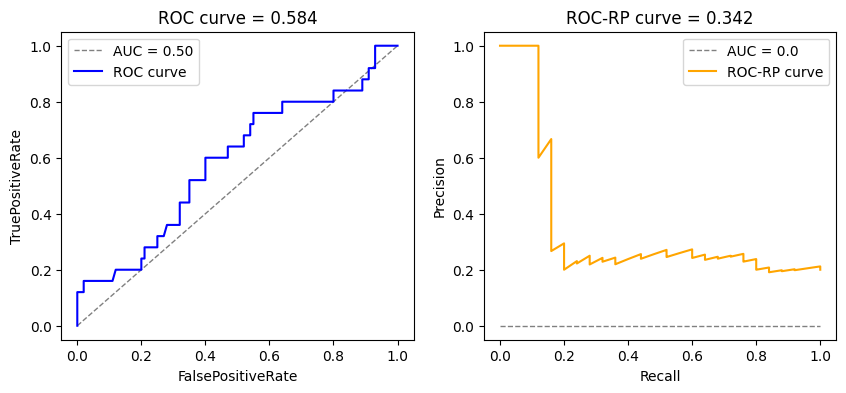

In [20]:
ROCcurves(model,X,Y)

125/125 [==============================] - 43s 340ms/step


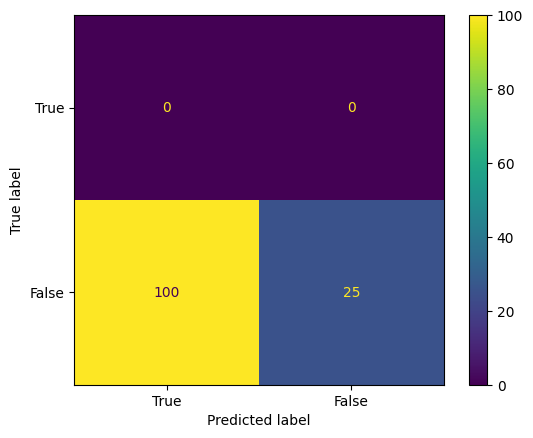

In [24]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,model.predict(to_tf_dateset(X,Y))[0]))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [ ]:
model.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

## Save model weights

In [ ]:

model.save("../data/BERT/weight/ConvolutionNetwork.h5")